In [ ]:
pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=bba3a7a66ac3bbc8ffe8db7b550f0458b0a5475aa18f471fcabdac5f61bbbb3f
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
pip install xgboost

In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [ ]:
pbp = nfl.import_pbp_data([2023])

2023 done.
Downcasting floats.


In [ ]:
pbp.to_csv("pbp.csv")

In [ ]:
print(pbp.shape)

(49458, 390)


In [ ]:
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != 'no_play')]

In [ ]:
pbp_clean.to_csv('nfl_pbp.csv')

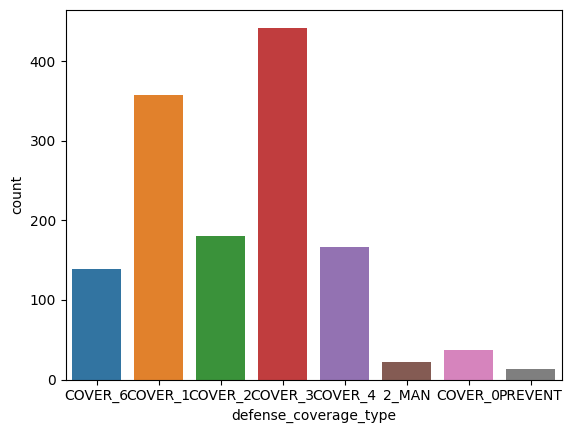

In [ ]:
explosive = pbp_clean[(pbp_clean['yards_gained'] >= 20)]
sns.countplot(x = explosive['defense_coverage_type'])
plt.show()

In [ ]:
refined_df = pbp_clean[['game_id', 'play_id', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box', 'number_of_pass_rushers', 'defense_coverage_type', 'was_pressure', 'yards_gained']]

In [ ]:
refined_df = refined_df.dropna()
refined_df.isna().sum()

game_id                   0
play_id                   0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
defense_coverage_type     0
was_pressure              0
yards_gained              0
dtype: int64

In [ ]:
refined_df

,game_id,play_id,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,defense_coverage_type,was_pressure,yards_gained
3,2023_01_ARI_WAS,77.0,S.Howell,2.0,7.0,72.0,3570.0,6.0,4.0,COVER_3,False,6.0
5,2023_01_ARI_WAS,124.0,S.Howell,1.0,10.0,64.0,3496.0,6.0,4.0,COVER_4,False,0.0
6,2023_01_ARI_WAS,147.0,S.Howell,2.0,10.0,64.0,3492.0,6.0,4.0,COVER_4,True,12.0
7,2023_01_ARI_WAS,172.0,S.Howell,1.0,10.0,52.0,3454.0,6.0,5.0,COVER_4,False,1.0
8,2023_01_ARI_WAS,197.0,S.Howell,2.0,9.0,51.0,3416.0,6.0,4.0,COVER_1,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
42244,2023_17_NYJ_CLE,4520.0,T.Siemian,1.0,10.0,51.0,71.0,4.0,4.0,COVER_2,False,10.0
42245,2023_17_NYJ_CLE,4545.0,T.Siemian,1.0,10.0,41.0,49.0,5.0,6.0,COVER_3,True,1.0
42246,2023_17_NYJ_CLE,4570.0,T.Siemian,2.0,9.0,40.0,25.0,4.0,4.0,COVER_2,False,8.0
42248,2023_17_NYJ_CLE,4595.0,T.Siemian,3.0,1.0,32.0,12.0,4.0,4.0,COVER_2,False,0.0


In [ ]:
array = []
for index, row in refined_df.iterrows():
  if(row['yards_gained'] >= 20.0):
    array.append(1)
  else:
    array.append(0)

In [ ]:
refined_df['explosive'] = array

In [ ]:
refined_df['down'] = refined_df['down'].astype('category')
df = refined_df.drop(columns = ['game_id', 'play_id', 'name', 'yards_gained'])
df = pd.get_dummies(df, columns = ['down'])
df = pd.get_dummies(df, columns = ['defense_coverage_type'])
df = pd.get_dummies(df, columns = ['was_pressure'])

In [ ]:
df

,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,explosive,down_1.0,down_2.0,down_3.0,down_4.0,defense_coverage_type_2_MAN,defense_coverage_type_COVER_0,defense_coverage_type_COVER_1,defense_coverage_type_COVER_2,defense_coverage_type_COVER_3,defense_coverage_type_COVER_4,defense_coverage_type_COVER_6,defense_coverage_type_PREVENT,was_pressure_False,was_pressure_True
3,7.0,72.0,3570.0,6.0,4.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
5,10.0,64.0,3496.0,6.0,4.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6,10.0,64.0,3492.0,6.0,4.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
7,10.0,52.0,3454.0,6.0,5.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
8,9.0,51.0,3416.0,6.0,4.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42244,10.0,51.0,71.0,4.0,4.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
42245,10.0,41.0,49.0,5.0,6.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
42246,9.0,40.0,25.0,4.0,4.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
42248,1.0,32.0,12.0,4.0,4.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df,df['explosive'],test_size=0.25, random_state=42)
X_train = X_train.drop(columns = ['explosive'])
X_test = X_test.drop(columns = ['explosive'])

In [ ]:
X_train.isna().sum()

ydstogo                          0
yardline_100                     0
game_seconds_remaining           0
defenders_in_box                 0
number_of_pass_rushers           0
down_1.0                         0
down_2.0                         0
down_3.0                         0
down_4.0                         0
defense_coverage_type_2_MAN      0
defense_coverage_type_COVER_0    0
defense_coverage_type_COVER_1    0
defense_coverage_type_COVER_2    0
defense_coverage_type_COVER_3    0
defense_coverage_type_COVER_4    0
defense_coverage_type_COVER_6    0
defense_coverage_type_PREVENT    0
was_pressure_False               0
was_pressure_True                0
dtype: int64

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['not_explosive','explosive'])
LR_pred

#print("Brier score: ", brier_score_loss(y_test, LR_pred))

,not_explosive,explosive
0,0.931539,0.068461
1,0.888666,0.111334
2,0.763321,0.236679
3,0.927366,0.072634
4,0.819194,0.180806
...,...,...
3730,0.900914,0.099086
3731,0.946156,0.053844
3732,0.929747,0.070253
3733,0.928607,0.071393


In [ ]:
LR_pred

,not_explosive,explosive
0,0.931539,0.068461
1,0.888666,0.111334
2,0.763321,0.236679
3,0.927366,0.072634
4,0.819194,0.180806
...,...,...
3730,0.900914,0.099086
3731,0.946156,0.053844
3732,0.929747,0.070253
3733,0.928607,0.071393


In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['not_explosive','explosive'])[['explosive']]

print("Brier score: ", brier_score_loss(y_test, RF_pred))

Brier score:  0.08924548098441504


In [ ]:
XGB = XGBClassifier(objective = "binary:logistic", random_state = 42)
XGB.fit(X_train, y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['not_explosive','explosive'])[['explosive']]
print("Brier score: ", brier_score_loss(y_test, XGB_pred))

Brier score:  0.08537575306745901


<Axes: ylabel='Feature'>

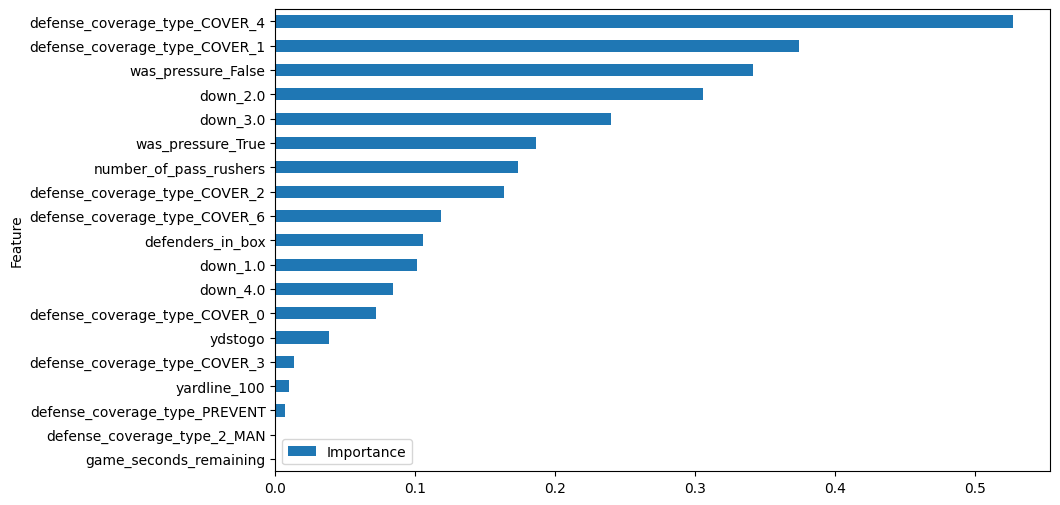

In [ ]:
coefficients = LR.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
make_predictions = df.drop('explosive', axis =1)
LR_predictions = pd.DataFrame(LR.predict_proba(make_predictions), columns = ['not_explosive', 'explosive_pred'])[['explosive_pred']]

explosive_preds = refined_df.reset_index().drop(columns = ['index'])
explosive_preds['explosive_pred'] = LR_predictions

explosive_preds['explosive_oe'] = explosive_preds['explosive'] - explosive_preds['explosive_pred']
table = explosive_preds.groupby('name').agg({'explosive': 'sum', 'explosive_pred': 'sum', 'explosive_oe': 'sum'}).reset_index().sort_values('explosive_oe', ascending=True)

In [ ]:
table

,name,explosive,explosive_pred,explosive_oe
10,B.Young,20,41.409048,-21.409048
61,M.Jones,17,35.346998,-18.346998
40,J.Burrow,21,33.934320,-12.934320
73,S.Howell,41,53.493317,-12.493317
42,J.Dobbs,29,40.349657,-11.349657
...,...,...,...,...
26,D.Prescott,52,42.150867,9.849133
46,J.Goff,54,44.037974,9.962026
63,M.Stafford,55,43.097348,11.902652
17,C.Stroud,61,40.213412,20.786588


In [ ]:
table.to_csv('Explosive Plays Over Expected.csv')